In [1]:
import pandas as pd
from finvizfinance.screener.overview import Overview
import yfinance as yf
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import classification_report
import talib as TA
import numpy as np
import hvplot.pandas
import matplotlib.pyplot as plt
from datetime import date
import pandas_ta as ta

In [2]:
criteria = Overview()

In [3]:
# Criteria Set from CANSLIM method
filters_dic = {'Price':'Over $5', 'EPS growthqtr over qtr':'Over 20%', 'EPS growthpast 5 years':'Over 15%', 'InstitutionalOwnership':'Under 90%', 
               'Return on Equity':'Over +15%', '52-Week High/Low':'0-10% below High', 'Shares Outstanding': 'Under 50M', 'Price': 'Over $5', 'Average Volume': 'Over 100K'}

In [4]:
criteria.set_filter(filters_dict=filters_dic)

In [5]:
screened_stocks_df = criteria.screener_view()

In [6]:
screened_stocks_df

Ticker                         Company              Sector  \
0   CLFD                Clearfield, Inc.          Technology   
1   CVLG  Covenant Logistics Group, Inc.         Industrials   
2    GLP              Global Partners LP              Energy   
3   MGPI           MGP Ingredients, Inc.  Consumer Defensive   
4   MUSA                 Murphy USA Inc.   Consumer Cyclical   
5   OTTR          Otter Tail Corporation           Utilities   
6   SRTS         Sensus Healthcare, Inc.          Healthcare   
7   USAK                 USA Truck, Inc.         Industrials   

                  Industry Country    Market Cap    P/E   Price  Change  \
0  Communication Equipment     USA  1.210000e+09  43.10  103.02 -0.0056   
1                 Trucking     USA  5.177500e+08   6.72   32.79  0.0403   
2      Oil & Gas Midstream     USA  9.426700e+08  12.45   28.30 -0.0018   
3           Packaged Foods     USA  2.230000e+09  20.19  101.95 -0.0414   
4         Specialty Retail     USA  6.300000e+09  13.19  287.55  0.0139   
5  Utilities - Diversified     USA  3.020000e+09  14.43   75.30 -0.0391   
6          Medical Devices     USA  1.768000e+08   8.71   11.19  0.0090   
7                 Trucking     USA  2.815200e+08   8.21   31.28  0.0026   

     Volume  
0  281565.0  
1  134089.0  
2   90589.0  
3  157615.0  
4  268666.0  
5  290545.0  
6  184328.0  
7  127419.0

In [7]:
ticker = screened_stocks_df["Ticker"]

In [8]:
all_stock_df = {}
classification_report_dic = {}
testing_report_dic = {}
predictions_df_dic = {}

ticker

0    CLFD
1    CVLG
2     GLP
3    MGPI
4    MUSA
5    OTTR
6    SRTS
7    USAK
Name: Ticker, dtype: object

The total return for CLFD is 6.84000396728508
The total return for CVLG is -2.619393825531058
The total return for GLP is -2.0416178703307253
The total return for MGPI is 29.19238853454562
The total return for MUSA is 36.926788330077784
The total return for OTTR is 3.13632011413576
The total return for SRTS is 0.1880016326905709
The total return for USAK is 8.154997825622722


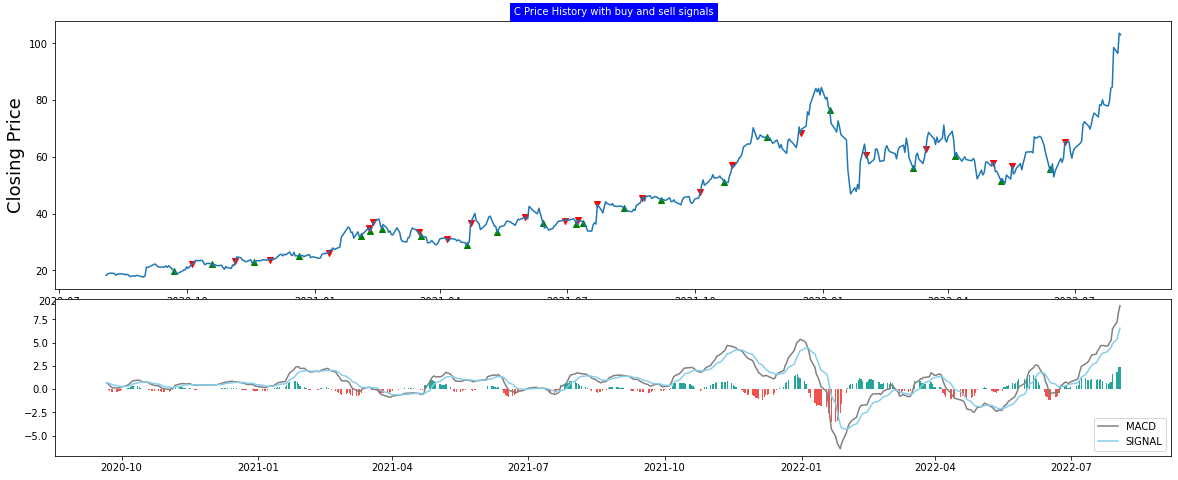

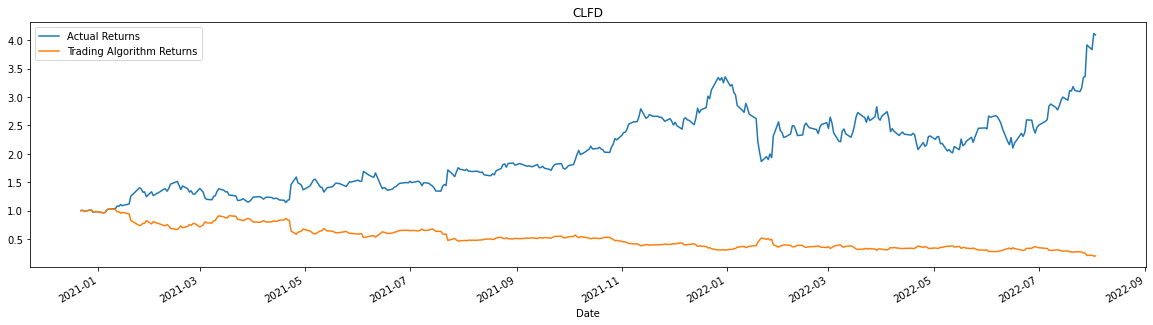

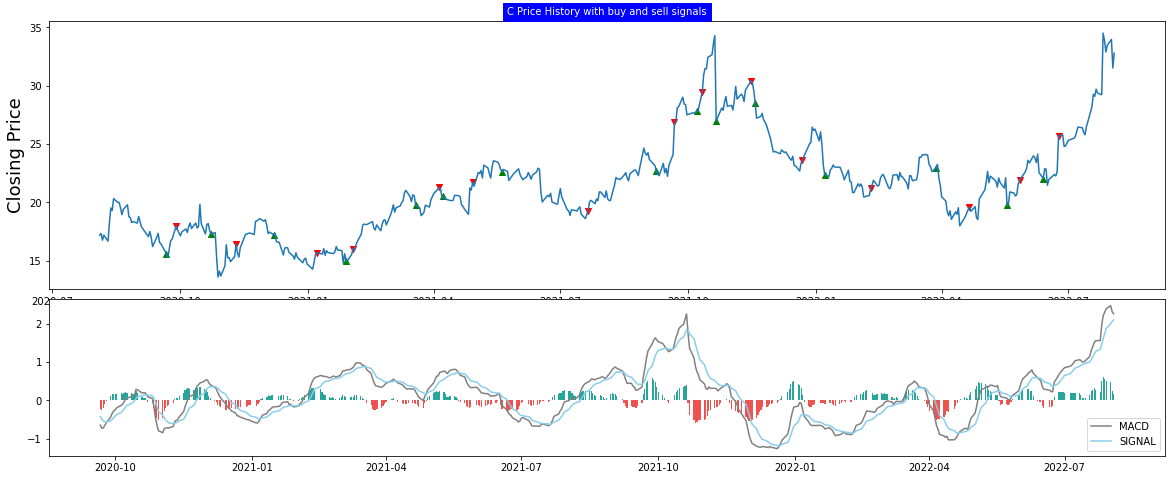

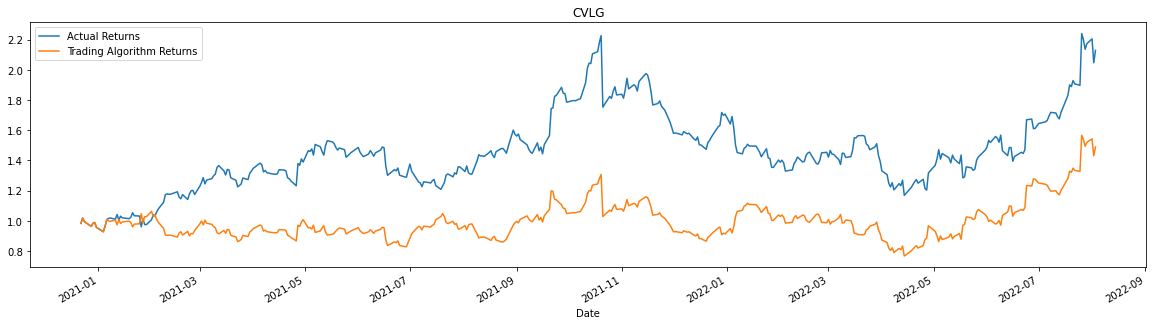

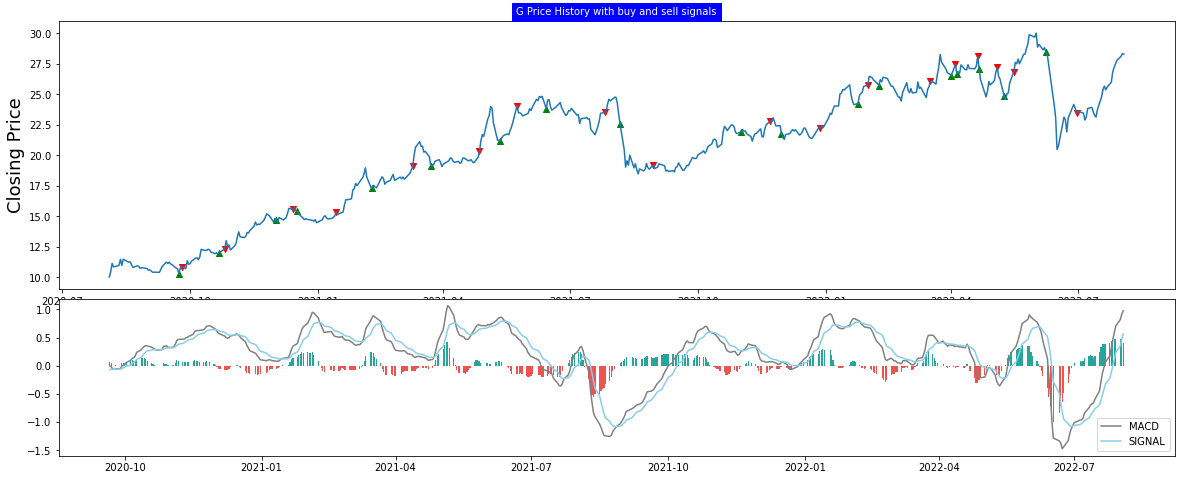

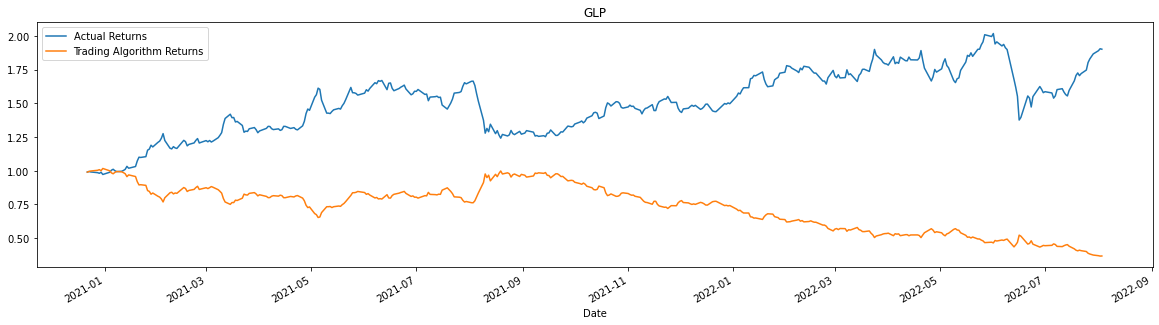

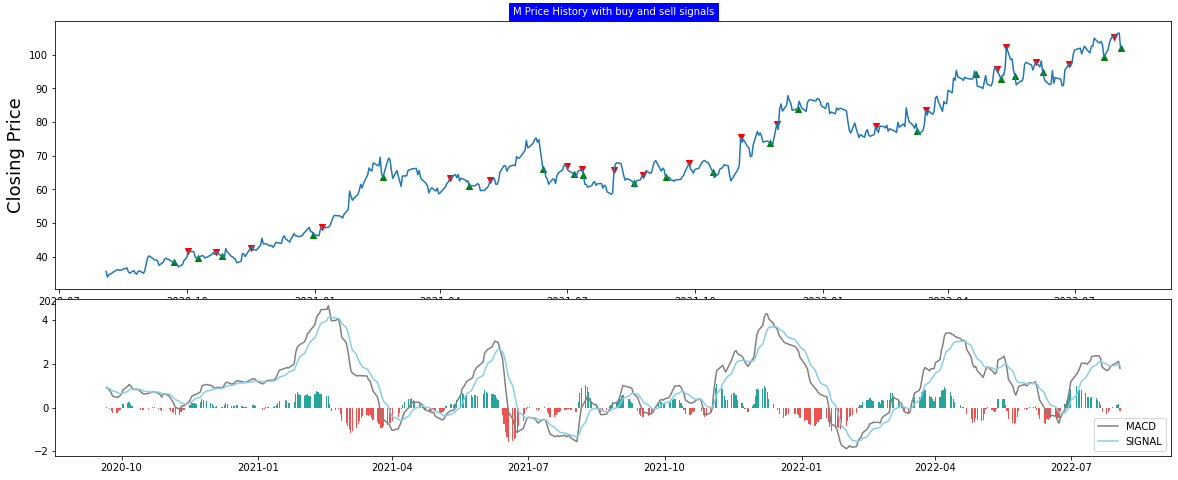

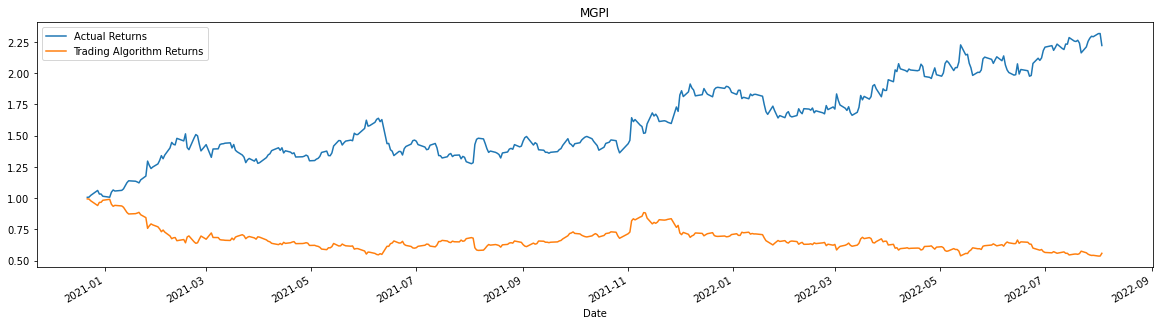

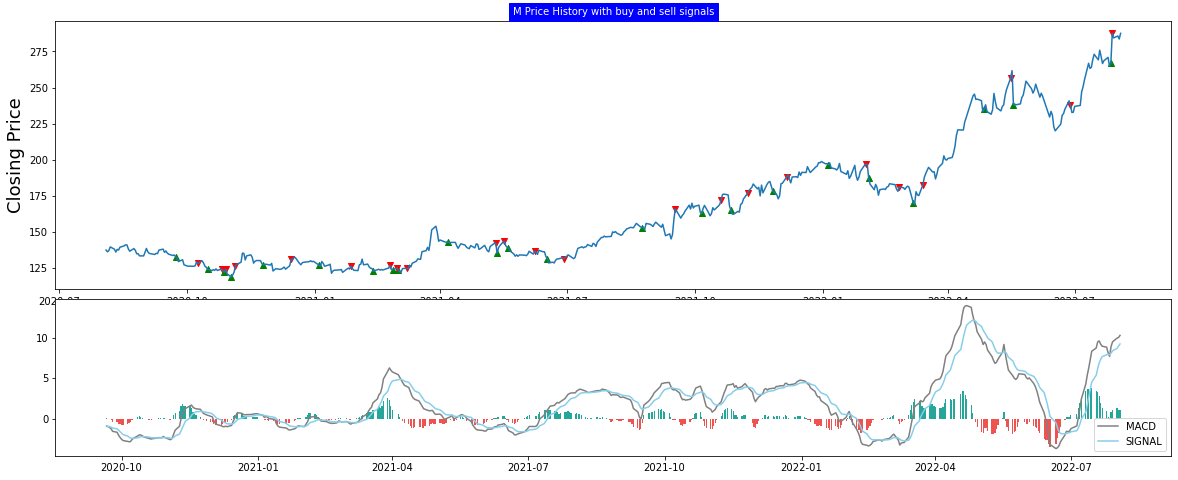

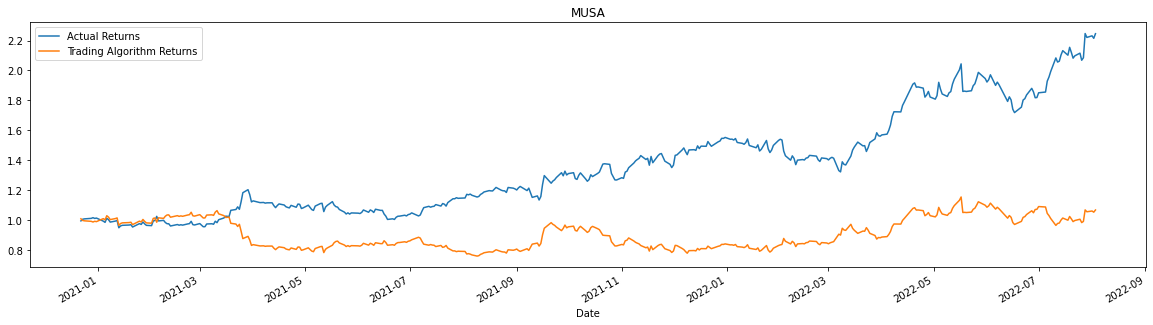

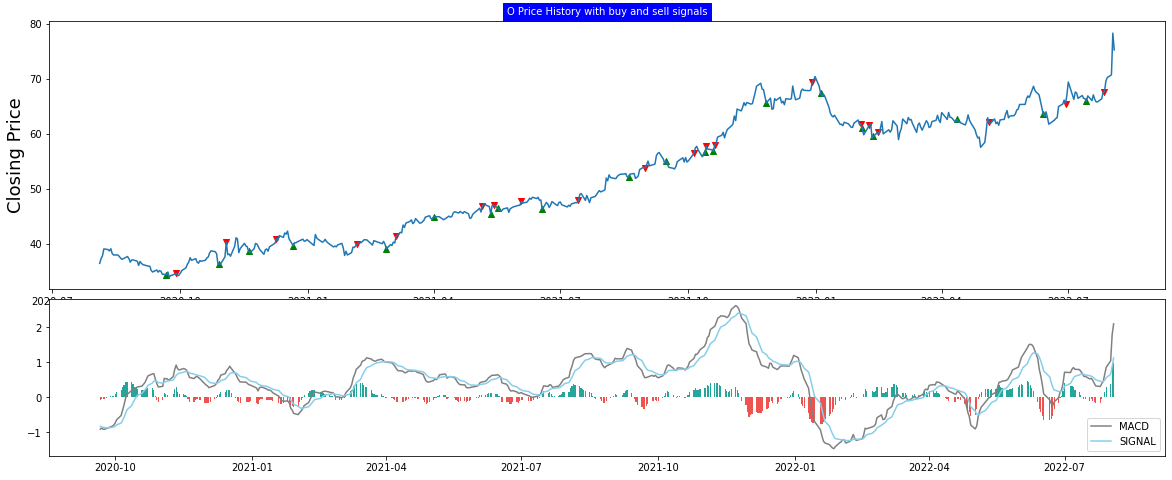

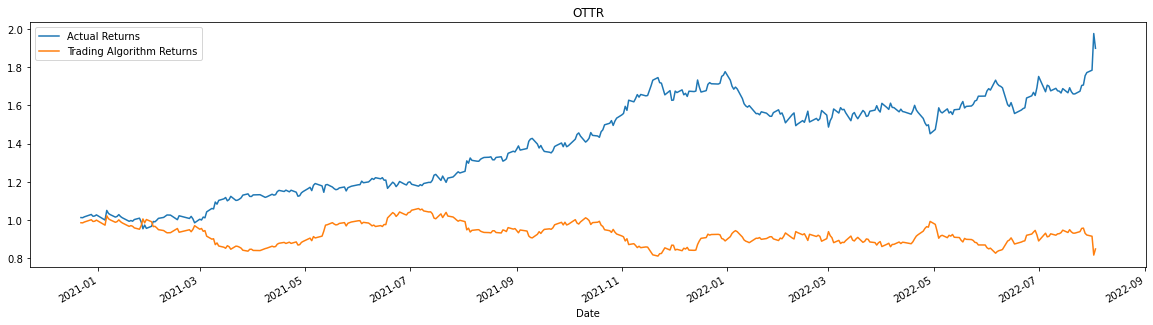

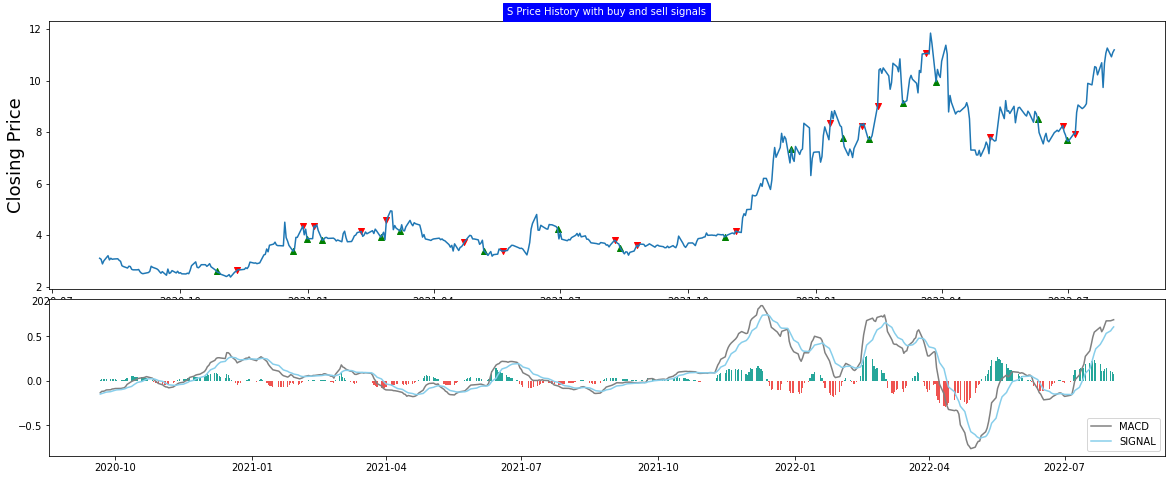

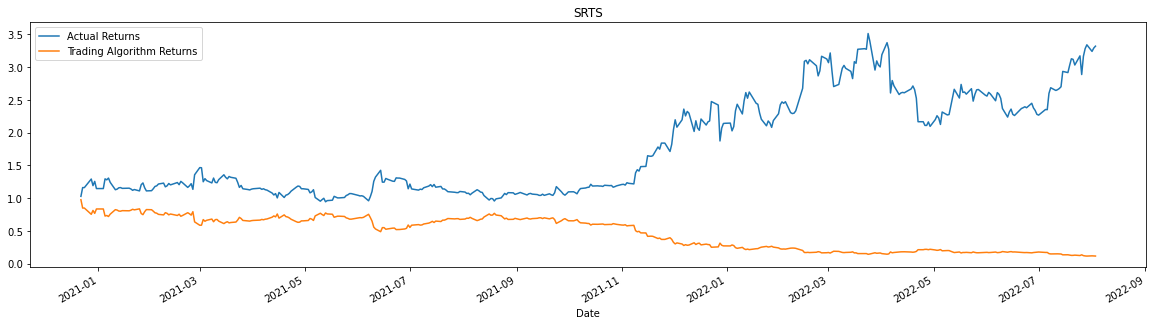

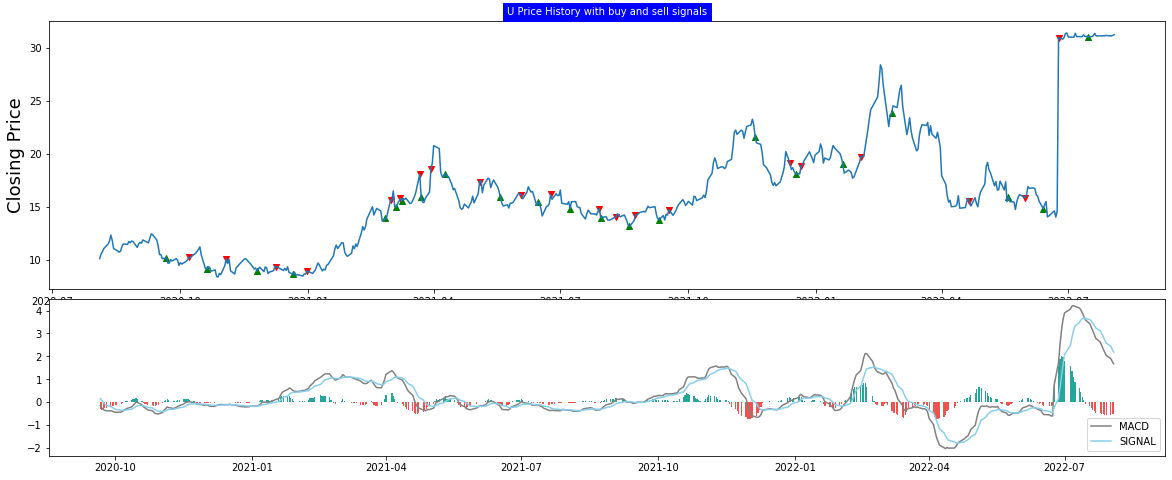

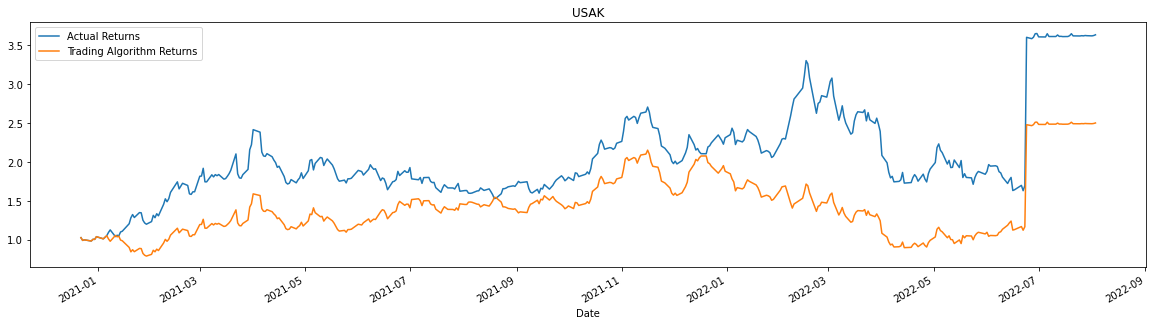

In [9]:
for ticker in ticker:
    stock = yf.Ticker(ticker)
    stock_hist = stock.history(period='2y')
    stock_hist = stock_hist.drop(columns=["Dividends", "Stock Splits"])
    stock_hist['Ticker'] = (ticker)
    col = stock_hist.pop('Ticker')
    stock_hist.insert(loc=0, column='Ticker', value=col)
    stock_hist['Actual Returns'] = stock_hist['Close'].pct_change()
    stock_hist.dropna()
    stock_hist.ta.macd(close='close', fast=12, slow=26, signal=9, append=True)
    pd.set_option("display.max_columns", None)  # show all columns
    
    stock_hist.dropna()
    stock_hist["Signal"]=0.0
    stock_hist.loc[(stock_hist["MACD_12_26_9"] < stock_hist["MACDs_12_26_9"]), "Signal"] = 1.0
    stock_hist.loc[(stock_hist["MACD_12_26_9"] > stock_hist["MACDs_12_26_9"]), "Signal"] = -1.0

        
    stock_hist["Entry/Exit"] = stock_hist["Signal"].diff()
    stock_ticker = stock_hist['Ticker']
    def buy_sell(stock_hist):
        signalBuy = []
        signalSell = []
        position = False 

        for i in range(len(stock_hist)):
            if stock_hist['MACD_12_26_9'][i] < stock_hist['MACDs_12_26_9'][i]:
                if position == False :
                    signalBuy.append(stock_hist['Close'][i])
                    signalSell.append(np.nan)
                    position = True
                else:
                    signalBuy.append(np.nan)
                    signalSell.append(np.nan)
            elif stock_hist['MACD_12_26_9'][i] > stock_hist['MACDs_12_26_9'][i]:
                if position == True:
                    signalBuy.append(np.nan)
                    signalSell.append(stock_hist['Close'][i])
                    position = False
                else:
                    signalBuy.append(np.nan)
                    signalSell.append(np.nan)
            else:
                signalBuy.append(np.nan)
                signalSell.append(np.nan)
        return pd.Series([signalBuy, signalSell])
    stock_hist['Buy_Signal_price'], stock_hist['Sell_Signal_price'] = buy_sell(stock_hist)
    
    def plot_macd(prices, macd, signal, hist):
        ax1, ax2 = plt.subplots(figsize=(20,8))
        ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
        ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

        ax1.plot(prices)
        ax1.set_title(ticker[0] + " Price History with buy and sell signals",fontsize=10, backgroundcolor='blue', color='white')
        ax1.set_xlabel(f'5 Year Chart of {stock_ticker[0]}' ,fontsize=18)
        ax1.set_ylabel('Closing Price' , fontsize=18)
        ax1.scatter(stock_hist.index , stock_hist['Buy_Signal_price'] , label = 'Buy' , marker = '^', color = 'green',alpha =1 )
        ax1.scatter(stock_hist.index , stock_hist['Sell_Signal_price'] , label = 'Sell' , marker = 'v', color = 'red',alpha =1 )
        ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
        ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')
        

        for i in range(len(prices)):
            if str(hist[i])[0] == '-':
                ax2.bar(prices.index[i], hist[i], color = '#ef5350')
            else:
                ax2.bar(prices.index[i], hist[i], color = '#26a69a')

        plt.legend(loc = 'lower right')

    plot_macd(stock_hist['Close'], stock_hist['MACD_12_26_9'], stock_hist['MACDs_12_26_9'], stock_hist['MACDh_12_26_9'])




    X= stock_hist[['MACD_12_26_9', 'MACDs_12_26_9']].shift().dropna().copy()
    y = stock_hist["Signal"].copy()
    training_begin = X.index.min()
    training_end = X.index.min() + DateOffset(months=3)
    
    X_train = X.loc[training_begin:training_end]
    y_train = y.loc[training_begin:training_end]

    # Create testing datasets

    X_test = X.loc[training_end:]
    y_test = y.loc[training_end:]
    # Standerdize the data

    scaler = StandardScaler()
    X_scaler = scaler.fit(X_train)
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    
    # Create classification report

    svm_model = svm.SVC()
    svm_model = svm_model.fit(X_train_scaled, y_train)

    training_signal_predictions = svm_model.predict(X_train_scaled)
    training_report = classification_report(y_train, training_signal_predictions, output_dict=True)
    classification_report_dic[ticker] = pd.DataFrame(training_report)
    
    # Backtest the machine learning algorithm
    
    testing_signal_predictions = svm_model.predict(X_test_scaled)
    testing_report = classification_report(y_test, testing_signal_predictions, output_dict=True)
    testing_report_dic[ticker] = pd.DataFrame(testing_report)
    
    # Compare actual and predicted returns

    predictions_df = pd.DataFrame(index=X_test.index)
    predictions_df["Predicted Signal"] = testing_signal_predictions
    predictions_df["Actual Returns"] = stock_hist["Actual Returns"]
    predictions_df["Trading Algorithm Returns"] = (
        stock_hist["Actual Returns"] * predictions_df["Predicted Signal"]
    )

    
    predictions_df_dic[ticker] = pd.DataFrame(predictions_df).head()
    
    # Set initial capital
    initial_capital = float(100000)

# Set the share size
    share_size = 500

# Buy a 500 share position when the dual moving average crossover Signal equals 1 (SMA50 is greater than SMA100)
# Sell a 500 share position when the dual moving average crossover Signal equals 0 (SMA50 is less than SMA100)
    stock_hist['Position'] = share_size * stock_hist['Signal']

# Determine the points in time where a 500 share position is bought or sold
    stock_hist['Entry/Exit Position'] = stock_hist['Position'].diff()

# Multiply the close price by the number of shares held, or the Position
    stock_hist['Portfolio Holdings'] = stock_hist['Close'] * stock_hist['Position']

# Subtract the amount of either the cost or proceeds of the trade from the initial capital invested
    stock_hist['Portfolio Cash'] = initial_capital - (stock_hist['Close'] * stock_hist['Entry/Exit Position']).cumsum()

# Calculate the total portfolio value by adding the portfolio cash to the portfolio holdings (or investments)
    stock_hist['Portfolio Total'] = stock_hist['Portfolio Cash'] + stock_hist['Portfolio Holdings']

# Calculate the portfolio daily returns
    stock_hist['Portfolio Daily Returns'] = stock_hist['Portfolio Total'].pct_change()

# Calculate the portfolio cumulative returns
    stock_hist['Portfolio Cumulative Returns'] = (1 + stock_hist['Portfolio Daily Returns']).cumprod() - 1

# Print the DataFrame
    
    
    (1 + predictions_df[["Actual Returns", "Trading Algorithm Returns"]]).cumprod().plot(title=ticker, figsize = (20,5))
    print(f"The total return for {ticker} is {(stock_hist['Portfolio Cumulative Returns'][-1]*100)}")
    
    name = str(ticker)
    all_stock_df[name] = stock_hist